Here is our first attempt at lengthscale inference for actual sequences!

We will be using a simpler, BER only version of the simulator, and we assume we know all parameters except for the lengthscale.

In [1]:
# Load our stuff
import pkgutil
from pathlib import Path
import numpy as np
from Bio import SeqIO
from Bio.Alphabet import IUPAC
from SHMModels.fitted_models import ContextModel
from keras import optimizers, Input, Model
from genDat import hot_encode_2d, gen_batch
from keras.models import Sequential
import keras.backend as K
import matplotlib.pyplot as plt
from keras.layers import (
    Dense,
    TimeDistributed,
    SimpleRNN,
    Dropout,
    Conv2D,
    Conv2DTranspose,
    Flatten,
    Conv1D,
    MaxPooling2D,
    Reshape,
    UpSampling2D,
)
import scipy
import math

##### USER INPUTS (Edit some of these to be CLI eventually)

# Path to germline sequence
germline_sequence = "data/gpt.fasta"
# Context model length and pos_mutating
context_model_length = 3
context_model_pos_mutating = 2
# Path to aid model
aid_context_model = "data/aid_logistic_3mer.csv"
# Num seqs and n_mutation rounds
n_seqs = 1
n_mutation_rounds = 1
# step size
step_size = 0.01
# batch size num epochs
batch_size = 500
num_epochs = 1000
steps_per_epoch = 1
gl1 = list(list(
    SeqIO.parse(germline_sequence, "fasta", alphabet=IUPAC.unambiguous_dna)
)[0].seq)
germline = list(list(
    SeqIO.parse(germline_sequence, "fasta", alphabet=IUPAC.unambiguous_dna)
)[0].seq)

Using TensorFlow backend.


In [2]:
# First, we want to identify our true parameter set and our starting parameter set.

n_samples = 10;max_steps = 4;n_imp_samples = 1;sampling_noise_sd = .01
start_model_params = { "base_rate" : 0.25,
                       "lengthscale" : .01,
                       "gp_sigma" : 2.0,
                       "gp_ridge" : .1
}
true_model_params = { "base_rate" : 0.25,
                       "lengthscale" : .025,
                       "gp_sigma" : 2.0,
                       "gp_ridge" : .1
}


In [3]:
n = np.size(germline)
c_array = np.zeros(n)
for i in range(n):
    c_array[i] = 1.0 * (germline[i] == 'C')
vals = np.random.poisson(lam = true_model_params['base_rate'], size = n)
vals = np.multiply(vals, c_array)
unit = []
for i in range(np.size(vals)):
    if vals[i] > 0:
        conts = (i-np.random.uniform(size = int(vals[i])))/n
        unit = np.append(unit, conts)

In [4]:
def make_se_kernel(x, lengthscale, sigma, gp_ridge):
    D = np.zeros([len(x), len(x)])
    upper_tri = np.triu_indices(len(x), 1)
    D[upper_tri] = ((np.array(x)[upper_tri[0]] - np.array(x)[upper_tri[1]])**2)
    D += D.T
    K = sigma**2 * np.exp(-D / (2 * lengthscale))
    np.fill_diagonal(K, K.diagonal() + gp_ridge)
    return K

def forward_sample_sequence_sgcp(sequence, params):
    n = np.size(sequence)
    vals = np.random.poisson(lam = params['base_rate'], size = n)
    # Only include prelesions at c site
    vals = np.multiply(vals, c_array)
    x = []
    for i in range(np.size(vals)):
        if vals[i] > 0:
            conts = (i-np.random.uniform(size = int(vals[i])))/n
            x = np.append(x, conts)
    N = np.size(x)
    K = make_se_kernel(x, params['lengthscale'], params['gp_sigma'], params['gp_ridge'])
    lambda_of_x = np.random.multivariate_normal(mean = np.zeros(N), cov = K)
    sigma_lambda_of_x = 1 / (1 + np.exp(-lambda_of_x))
    uniforms = np.random.uniform(low = 0, high = 1, size = len(x))
    A_and_g = [(xi, li) for (xi, si, li, u) in zip(x, sigma_lambda_of_x, lambda_of_x, uniforms) if u < si]
    A_tilde_and_g = [(xi, li) for (xi, si, li, u) in zip(x, sigma_lambda_of_x, lambda_of_x, uniforms) if u >= si]
    A = [a for (a, g) in A_and_g]
    A_tilde = [at for (at, g) in A_tilde_and_g]
    g = [g for (a, g) in A_and_g + A_tilde_and_g]
    return({ "A" : A, "A_tilde" : A_tilde, "g" : g})

def sample_seq(sequence, params):
    new_seq = sequence[:]
    res = forward_sample_sequence_sgcp(sequence,params)
    A = np.unique(np.ceil(np.multiply(res['A'],len(sequence))))
    muts = np.random.choice(a = ['A','G','C','T'], size = len(A))
    for i in range(len(A)):
        new_seq[int(A[i])] = muts[i]
    A = (np.ceil(np.multiply(res['A'],len(sequence))))
    A_tilde = (np.ceil(np.multiply(res['A_tilde'],len(sequence))))
    g = res['g']
    return({"seq": new_seq,  "A" : A, "A_tilde" : A_tilde, "g" : g})
def process_latent(seq_res):
    n = len(seq_res['seq'])
    A = seq_res['A']
    A_tilde = seq_res['A_tilde']
    g = seq_res['g']
    A_long = np.zeros(n)
    A_tilde_long = np.zeros(n)
    g_long = np.zeros(n)
    k = 0
    for i in A:
        A_long[int(i)] = A_long[int(i)]+1
        g_long[int(i)] = g[k]
        k = k+1
    for i in A_tilde:
        A_tilde_long[int(i)] = A_tilde_long[int(i)]+1
        g_long[int(i)] = g[k]
        k = k+1
    return(np.stack([g_long,A_long, A_tilde_long],axis = 1))

In [5]:
# Get a 2d hot encoding of a sequence
def hot_encode_2d(seq):
    seq_hot = np.zeros((len(seq), 4, 1))
    for j in range(len(seq)):
        seq_hot[j, 0, 0] = seq[j] == "A"
        seq_hot[j, 1, 0] = seq[j] == "T"
        seq_hot[j, 2, 0] = seq[j] == "G"
        seq_hot[j, 3, 0] = seq[j] == "C"
    return seq_hot

def gen_batch(seq, params, batch_size):
    mut = []
    les = []
    for i in range(batch_size):
        temp = sample_seq(seq, params)
        mut.append(hot_encode_2d(temp['seq']))
        les.append(process_latent(temp))
    return np.array(mut),np.array(les)

In [6]:
# We want a custom loss that only penalizes GP at lesion values
def custom_loss(y_true, y_pred):
    g_true = y_true[:,:,0]
    g_pred = y_pred[:,:,0]
    ind = K.cast((y_true[:,:,1]+y_true[:,:,2]) > 0, 'float32')
    g_adj = (g_true-g_pred)*ind
    return K.mean(K.square(K.stack((g_adj,y_true[:,:,1]-y_pred[:,:,1],y_true[:,:,2]-y_pred[:,:,2]))))


# Let's build our encoder. Seq is of length 308.
input_seq = Input(shape=(308, 4, 1))

# We add 2 convolutional layers.
x = Conv2D(16, (3, 6), activation="relu", padding="same")(input_seq)
x = MaxPooling2D((2, 1), padding="same")(x)
x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

# Now we decode back up
x = Conv2DTranspose(
    filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
)(x)
x = Conv2DTranspose(
    filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
)(x)
x = Conv2DTranspose(
    filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="relu"
)(x)
x = Flatten()(x)
# I think ReLU is fine here because the values are nonnegative?
decoded = Dense(units=(308*3), activation="linear")(x)
reshaped = Reshape((308,3))(decoded)

# at this point the "decoded" representation is a 3*308 vector indicating our predicted # of
#lesions, prelesions, gp values at each site.
autoencoder = Model(input_seq, reshaped)
autoencoder.compile(optimizer="adam", loss=custom_loss)

print(autoencoder.summary(90))


Model: "model_1"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
input_1 (InputLayer)                    (None, 308, 4, 1)                   0             
__________________________________________________________________________________________
conv2d_1 (Conv2D)                       (None, 308, 4, 16)                  304           
__________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)          (None, 154, 4, 16)                  0             
__________________________________________________________________________________________
conv2d_2 (Conv2D)                       (None, 154, 4, 8)                   1160          
__________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)          (None, 77, 2, 8)                 

In [7]:
def genTraining(batch_size):
    while True:
        # Get training data for step
        mut,les = gen_batch(germline,start_model_params,batch_size)
        yield mut,les
t_batch_data, t_batch_labels = gen_batch(germline,start_model_params, 1000)
# Train
history = autoencoder.fit_generator(
    genTraining(batch_size),
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=(t_batch_data, t_batch_labels),
    verbose=2,
)

Epoch 1/1000
 - 6s - loss: 0.0946 - val_loss: 0.0910
Epoch 2/1000
 - 4s - loss: 0.0898 - val_loss: 0.0906
Epoch 3/1000
 - 4s - loss: 0.0861 - val_loss: 0.0899
Epoch 4/1000
 - 4s - loss: 0.0879 - val_loss: 0.0892
Epoch 5/1000
 - 4s - loss: 0.0863 - val_loss: 0.0897
Epoch 6/1000
 - 4s - loss: 0.0916 - val_loss: 0.0895
Epoch 7/1000
 - 4s - loss: 0.0947 - val_loss: 0.0891
Epoch 8/1000
 - 4s - loss: 0.0881 - val_loss: 0.0891
Epoch 9/1000
 - 4s - loss: 0.0884 - val_loss: 0.0892
Epoch 10/1000
 - 4s - loss: 0.0897 - val_loss: 0.0893
Epoch 11/1000
 - 4s - loss: 0.0868 - val_loss: 0.0893
Epoch 12/1000
 - 4s - loss: 0.0881 - val_loss: 0.0892
Epoch 13/1000
 - 4s - loss: 0.0889 - val_loss: 0.0891
Epoch 14/1000
 - 4s - loss: 0.0891 - val_loss: 0.0891
Epoch 15/1000
 - 4s - loss: 0.0902 - val_loss: 0.0891
Epoch 16/1000
 - 4s - loss: 0.0870 - val_loss: 0.0891
Epoch 17/1000
 - 4s - loss: 0.0886 - val_loss: 0.0891
Epoch 18/1000
 - 4s - loss: 0.0871 - val_loss: 0.0890
Epoch 19/1000
 - 4s - loss: 0.0925 - 

Epoch 152/1000
 - 4s - loss: 0.0585 - val_loss: 0.0613
Epoch 153/1000
 - 4s - loss: 0.0613 - val_loss: 0.0611
Epoch 154/1000
 - 4s - loss: 0.0655 - val_loss: 0.0608
Epoch 155/1000
 - 4s - loss: 0.0612 - val_loss: 0.0606
Epoch 156/1000
 - 4s - loss: 0.0614 - val_loss: 0.0605
Epoch 157/1000
 - 4s - loss: 0.0615 - val_loss: 0.0606
Epoch 158/1000
 - 4s - loss: 0.0630 - val_loss: 0.0605
Epoch 159/1000
 - 4s - loss: 0.0627 - val_loss: 0.0606
Epoch 160/1000
 - 4s - loss: 0.0600 - val_loss: 0.0604
Epoch 161/1000
 - 4s - loss: 0.0604 - val_loss: 0.0603
Epoch 162/1000
 - 4s - loss: 0.0603 - val_loss: 0.0603
Epoch 163/1000
 - 4s - loss: 0.0585 - val_loss: 0.0602
Epoch 164/1000
 - 4s - loss: 0.0599 - val_loss: 0.0602
Epoch 165/1000
 - 4s - loss: 0.0606 - val_loss: 0.0601
Epoch 166/1000
 - 4s - loss: 0.0586 - val_loss: 0.0601
Epoch 167/1000
 - 4s - loss: 0.0610 - val_loss: 0.0614
Epoch 168/1000
 - 4s - loss: 0.0640 - val_loss: 0.0601
Epoch 169/1000
 - 4s - loss: 0.0592 - val_loss: 0.0612
Epoch 170/

Epoch 301/1000
 - 4s - loss: 0.0601 - val_loss: 0.0578
Epoch 302/1000
 - 4s - loss: 0.0567 - val_loss: 0.0580
Epoch 303/1000
 - 4s - loss: 0.0566 - val_loss: 0.0577
Epoch 304/1000
 - 4s - loss: 0.0578 - val_loss: 0.0577
Epoch 305/1000
 - 4s - loss: 0.0579 - val_loss: 0.0579
Epoch 306/1000
 - 4s - loss: 0.0597 - val_loss: 0.0576
Epoch 307/1000
 - 4s - loss: 0.0589 - val_loss: 0.0583
Epoch 308/1000
 - 4s - loss: 0.0601 - val_loss: 0.0578
Epoch 309/1000
 - 4s - loss: 0.0560 - val_loss: 0.0576
Epoch 310/1000
 - 4s - loss: 0.0580 - val_loss: 0.0578
Epoch 311/1000
 - 4s - loss: 0.0573 - val_loss: 0.0578
Epoch 312/1000
 - 4s - loss: 0.0576 - val_loss: 0.0577
Epoch 313/1000
 - 4s - loss: 0.0574 - val_loss: 0.0577
Epoch 314/1000
 - 4s - loss: 0.0569 - val_loss: 0.0575
Epoch 315/1000
 - 4s - loss: 0.0583 - val_loss: 0.0573
Epoch 316/1000
 - 4s - loss: 0.0568 - val_loss: 0.0573
Epoch 317/1000
 - 4s - loss: 0.0594 - val_loss: 0.0574
Epoch 318/1000
 - 4s - loss: 0.0562 - val_loss: 0.0574
Epoch 319/

Epoch 450/1000
 - 4s - loss: 0.0561 - val_loss: 0.0566
Epoch 451/1000
 - 4s - loss: 0.0553 - val_loss: 0.0568
Epoch 452/1000
 - 4s - loss: 0.0583 - val_loss: 0.0566
Epoch 453/1000
 - 4s - loss: 0.0574 - val_loss: 0.0566
Epoch 454/1000
 - 4s - loss: 0.0574 - val_loss: 0.0566
Epoch 455/1000
 - 4s - loss: 0.0584 - val_loss: 0.0565
Epoch 456/1000
 - 4s - loss: 0.0548 - val_loss: 0.0565
Epoch 457/1000
 - 4s - loss: 0.0594 - val_loss: 0.0565
Epoch 458/1000
 - 4s - loss: 0.0583 - val_loss: 0.0565
Epoch 459/1000
 - 4s - loss: 0.0543 - val_loss: 0.0565
Epoch 460/1000
 - 4s - loss: 0.0572 - val_loss: 0.0565
Epoch 461/1000
 - 4s - loss: 0.0551 - val_loss: 0.0565
Epoch 462/1000
 - 4s - loss: 0.0548 - val_loss: 0.0568
Epoch 463/1000
 - 4s - loss: 0.0564 - val_loss: 0.0568
Epoch 464/1000
 - 4s - loss: 0.0590 - val_loss: 0.0567
Epoch 465/1000
 - 4s - loss: 0.0582 - val_loss: 0.0567
Epoch 466/1000
 - 4s - loss: 0.0554 - val_loss: 0.0566
Epoch 467/1000
 - 4s - loss: 0.0574 - val_loss: 0.0568
Epoch 468/

Epoch 599/1000
 - 4s - loss: 0.0566 - val_loss: 0.0563
Epoch 600/1000
 - 4s - loss: 0.0570 - val_loss: 0.0566
Epoch 601/1000
 - 4s - loss: 0.0602 - val_loss: 0.0563
Epoch 602/1000
 - 4s - loss: 0.0574 - val_loss: 0.0563
Epoch 603/1000
 - 4s - loss: 0.0572 - val_loss: 0.0564
Epoch 604/1000
 - 4s - loss: 0.0585 - val_loss: 0.0562
Epoch 605/1000
 - 4s - loss: 0.0574 - val_loss: 0.0561
Epoch 606/1000
 - 4s - loss: 0.0568 - val_loss: 0.0562
Epoch 607/1000
 - 4s - loss: 0.0549 - val_loss: 0.0563
Epoch 608/1000
 - 4s - loss: 0.0561 - val_loss: 0.0562
Epoch 609/1000
 - 4s - loss: 0.0567 - val_loss: 0.0568
Epoch 610/1000
 - 4s - loss: 0.0552 - val_loss: 0.0564
Epoch 611/1000
 - 4s - loss: 0.0562 - val_loss: 0.0563
Epoch 612/1000
 - 4s - loss: 0.0554 - val_loss: 0.0567
Epoch 613/1000
 - 4s - loss: 0.0577 - val_loss: 0.0565
Epoch 614/1000
 - 4s - loss: 0.0563 - val_loss: 0.0563
Epoch 615/1000
 - 4s - loss: 0.0563 - val_loss: 0.0565
Epoch 616/1000
 - 4s - loss: 0.0582 - val_loss: 0.0566
Epoch 617/

Epoch 748/1000
 - 4s - loss: 0.0561 - val_loss: 0.0560
Epoch 749/1000
 - 4s - loss: 0.0542 - val_loss: 0.0560
Epoch 750/1000
 - 4s - loss: 0.0588 - val_loss: 0.0561
Epoch 751/1000
 - 4s - loss: 0.0558 - val_loss: 0.0561
Epoch 752/1000
 - 4s - loss: 0.0561 - val_loss: 0.0561
Epoch 753/1000
 - 4s - loss: 0.0577 - val_loss: 0.0560
Epoch 754/1000
 - 4s - loss: 0.0548 - val_loss: 0.0559
Epoch 755/1000
 - 4s - loss: 0.0559 - val_loss: 0.0558
Epoch 756/1000
 - 4s - loss: 0.0578 - val_loss: 0.0559
Epoch 757/1000
 - 4s - loss: 0.0557 - val_loss: 0.0559
Epoch 758/1000
 - 4s - loss: 0.0540 - val_loss: 0.0559
Epoch 759/1000
 - 4s - loss: 0.0581 - val_loss: 0.0560
Epoch 760/1000
 - 4s - loss: 0.0569 - val_loss: 0.0562
Epoch 761/1000
 - 4s - loss: 0.0576 - val_loss: 0.0560
Epoch 762/1000
 - 4s - loss: 0.0557 - val_loss: 0.0561
Epoch 763/1000
 - 4s - loss: 0.0593 - val_loss: 0.0561
Epoch 764/1000
 - 4s - loss: 0.0558 - val_loss: 0.0560
Epoch 765/1000
 - 4s - loss: 0.0558 - val_loss: 0.0560
Epoch 766/

Epoch 897/1000


KeyboardInterrupt: 

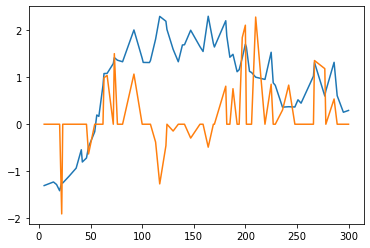

In [8]:
plt.plot((np.where(c_array>0))[0],autoencoder.predict(t_batch_data)[100,:,0][c_array>0])
plt.plot((np.where(c_array>0))[0],t_batch_labels[100,:,0][c_array>0])

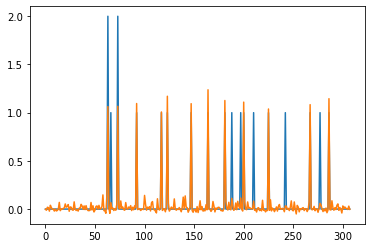

In [9]:
plt.plot(t_batch_labels[100,:,1])
plt.plot(autoencoder.predict(t_batch_data)[100,:,1])

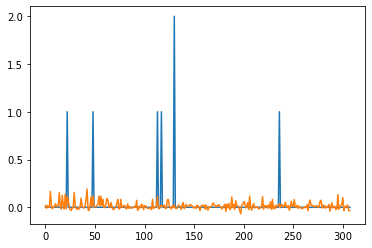

In [10]:
plt.plot(t_batch_labels[100,:,2])
plt.plot(autoencoder.predict(t_batch_data)[100,:,2])

In [11]:
def complete_data_sample_around_true_states_sgcp(complete_data,
                                                 params,
                                                 sampling_sd = .1):
    ## each element of observed_data is a list with A (the thinned
    ## points) lambda (the gp at the unthinned points), and x (the
    ## unthinned points).
    A = complete_data['A']
    A_tilde = complete_data['A_tilde']
    g = complete_data['g']
    
    N = np.size(g)
    K = make_se_kernel(np.append(np.array(A), np.array(A_tilde)), params['lengthscale'], sampling_sd, params['gp_ridge'])
    lambda_of_x = np.random.multivariate_normal(mean = np.zeros(N), cov = K)
    g_sample = g + lambda_of_x
    
    is_log_prob = sum(np.log(scipy.stats.norm.pdf(g_sample - g, loc = 0, scale = sampling_sd)))
    complete_data_log_prob,pois,thinning, gp = sgcp_complete_data_log_prob(A, A_tilde, g_sample, current_model_params['base_rate'], current_model_params['lengthscale'], current_model_params['gp_sigma'], current_model_params['gp_ridge'])
    log_w = complete_data_log_prob - is_log_prob
    return ({ "A" : A, "A_tilde" : A_tilde, "g" : g_sample, "w" : np.exp(log_w)},pois,thinning, gp)
def sequence_complete_data_log_prob(seq, gl_seq, A, A_tilde, g, model_params):
    lambda_star = model_params['lambda_star']
    lengthscale = model_params['lengthscale']
    sigma = model_params['sigma']
    gp_ridge = model_params['gp_ridge']
    ber_params = model_params['ber_params']
    sgcp_log_prob, pois,thinning, gp = sgcp_complete_data_log_prob(A, A_tilde, g, lambda_star, lengthscale, sigma, gp_ridge)
    sequence_given_sgcp_log_prob = sequence_log_prob_given_lesions(seq, gl_seq, A, ber_params)
    return(sgcp_log_prob + sequence_given_sgcp_log_prob)
def sgcp_complete_data_log_prob(A, A_tilde, g, lambda_star, lengthscale, sigma, gp_ridge):
    K = len(A)
    M = len(A_tilde)
    pois = (K + M) * np.log(lambda_star) - lambda_star - math.lgamma(K + M + 1)
    thinning = thinning_log_prob(g, K, M)
    gp_kern_ridged = make_se_kernel(np.append(np.array(A), np.array(A_tilde)), lengthscale, sigma, gp_ridge)
    gp = np.log(scipy.stats.multivariate_normal.pdf(g, mean = np.zeros(len(g)), cov = gp_kern_ridged))
    
    return(pois + thinning + gp, pois, thinning, gp)
def thinning_log_prob(g, K, M):
    if(K == 0 and M == 0):
        return(0)
    elif(K == 0 and M > 0):
        return(sum(np.log(logistic(-g))))
    elif(K > 0 and M == 0):
        return(sum(np.log(logistic(g))))
    else:
        return(sum(np.log(logistic(g[range(K)]))) + sum(np.log(logistic(-g[range(K, K+M)]))))
def logistic(x):
    return(1 / (1 + np.exp(-x)))

def logit(p):
    return(np.log(p / (1 - p)))
def discrete_to_interval(i, seq_length):
    return (i - np.random.uniform(low = 0, high = 1, size = 1)) / seq_length
def lengthscale_inference(x_list, g_list, weights, l_test_grid, model_params, full_grid = False):
    log_probs = np.zeros(len(l_test_grid))
    for (ls, ls_idx) in zip(l_test_grid, range(len(l_test_grid))):
        g_log_p_at_test = 0.
        for i in range(len(x_list)):
            g = g_list[i]
            K = make_se_kernel(x_list[i], lengthscale = ls, sigma = model_params['gp_sigma'], gp_ridge = model_params['gp_ridge'])
            g_log_p_at_test += weights[i] * np.log(scipy.stats.multivariate_normal.pdf(g, cov = K))
        log_probs[ls_idx] = g_log_p_at_test
    if full_grid:
        return(l_test_grid,log_probs)
    else:
        return(l_test_grid[np.argmax(log_probs)])
    

In [12]:
real_sample, real_labels  = gen_batch(germline,true_model_params, 300)
pred_labels = autoencoder.predict(real_sample)

In [13]:
current_model_params = start_model_params
n_imp_samples = 200
sampling_noise_sd = 0.1
x_list = []
g_list = []
w_list = []
ll_list= []
for i in range(300):
    for j in range(n_imp_samples):
        # Sample lesions and prelesions, and get full GP values
        new_A = np.multiply(c_array,np.random.poisson(lam = np.maximum(pred_labels[i,:,1],0)))
        new_A_tilde = np.multiply(c_array,np.random.poisson(lam = np.maximum(pred_labels[i,:,2],0)))
        g_full = pred_labels[i,:,0]
        # Now, we want to include only lesion sites on unit interval, as well as GP values for those sites
        g = []
        A_unit = []
        A_tilde_unit = []
        for p in range(308):
            if new_A[p] >0 :
                for q in range(int(new_A[p])):
                    g=np.append(g,g_full[p])
                    A_unit=np.append(A_unit, discrete_to_interval(p,308))
        for p in range(308):
            if new_A_tilde[p] >0 :
                for q in range(int(new_A_tilde[p])):
                    g= np.append(g,g_full[p])
                    A_tilde_unit= np.append(A_tilde_unit,discrete_to_interval(p,308))
        
                    
        
        complete_data = {"A": A_unit, "A_tilde": A_tilde_unit, "g": g}
        imp_sam,pois,thinning, gp= complete_data_sample_around_true_states_sgcp(complete_data = complete_data,
                                                                   params = current_model_params,
                                                                   sampling_sd = sampling_noise_sd)
        ll_list.append([pois,thinning, gp])
        x_list.append(np.append(complete_data["A"], imp_sam["A_tilde"]))
        g_list.append(imp_sam["g"])
        w_list.append(imp_sam["w"])

(array([255.,  12.,   7.,  11.,  10.,   0.,   1.,   1.,   1.,   2.]),
 array([1.        , 1.22554784, 1.45109569, 1.67664353, 1.90219138,
        2.12773922, 2.35328707, 2.57883491, 2.80438276, 3.0299306 ,
        3.25547845]),
 <a list of 10 Patch objects>)

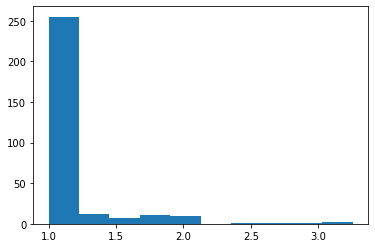

In [14]:
w_list_ess = []
for i in range(300):
    w_list_norm = np.array(w_list[n_imp_samples*i:n_imp_samples*(i+1)])/sum(w_list[n_imp_samples*i:n_imp_samples*(i+1)])
    w_list_ess.append(1.0/np.sum(np.square(w_list_norm)))
plt.hist(w_list_ess)

In [15]:
l_test = np.linspace(.001, .1, 40)
grid,probs = lengthscale_inference(x_list, g_list, w_list, l_test_grid = l_test, model_params = current_model_params, full_grid = True)

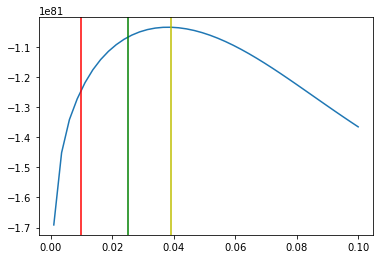

In [16]:

plt.plot(l_test,probs)
plt.axvline(x=start_model_params["lengthscale"], color = 'r')
plt.axvline(x= true_model_params["lengthscale"], color = 'g')
plt.axvline(x = l_test[np.argmax(probs)], color = 'y')